## Objective:
Using historical data on loans from Lending Club, create a model that can identify the best loans for a prospective lender to fund.  
  
## Approach:
Create a logistic regression model to identify the lowest-risk (lowest likelihood of being late on payments or defaulting) loans for future investment. 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    f1_score, 
    precision_score, 
    recall_score,
    roc_auc_score,
    roc_curve)
from sklearn import metrics
import seaborn as sns

warnings.filterwarnings('ignore')

## Data Preparation
 - Note there are loan datasets in the data directory as well as in the archive folder within that directory (these files are for the same date ranges, but the datasets are not identical). The relationship between these datasets is unclear. This analysis will only focus on the data present directly in the data directory. 

In [2]:
# read in all loan data
df = pd.DataFrame()

for filename in os.listdir('data'):
    if '.csv.gz' in filename:
        add_df = pd.read_csv('data/' + filename)
        add_df['quarter'] = filename.replace('.csv.gz', '')
        df = pd.concat([df, add_df])

df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(438991, 56)


,id,funded_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,loan_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,quarter
0,88215489,9600,36 months,17.99%,347.02,Site Guard Supervisor,3 years,MORTGAGE,24000.0,Fully Paid,...,100.0,66.7,0,21326,15900,NaN,NaN,NaN,NaN,2016Q3
1,84423268,12000,60 months,11.49%,263.86,Project Advocate,8 years,MORTGAGE,75000.0,Fully Paid,...,100.0,20.0,0,28250,84000,NaN,NaN,NaN,NaN,2016Q3
2,84623504,25500,36 months,15.59%,891.36,"Director, Business Services Unit",10+ years,MORTGAGE,108100.0,Fully Paid,...,86.7,0.0,0,83989,7100,NaN,NaN,NaN,NaN,2016Q3
3,85530090,10250,36 months,16.99%,365.39,manager,5 years,RENT,28500.0,Fully Paid,...,100.0,0.0,0,13449,18900,NaN,NaN,NaN,NaN,2016Q3
4,85390851,6000,36 months,9.49%,192.17,confidential Aid,10+ years,RENT,66000.0,Current,...,97.7,0.0,2,3810,11500,NaN,NaN,NaN,NaN,2016Q3


### Definition of Target Variable
 - The riskier loans are the ones that have been charged off (written off as a loss), or are late on payment
 - Target variable risky_loan is defined as a loan with loan_status of Charged Off, Late (31-120 days), or Late (16-30 days)
 - ~12% of loans in the entire dataset are deemed risky
 - When fitting the logistic regression model, it will be necessary to account for the imbalanced data to not overly predict the majority class

In [3]:
df['risky_loan'] = (df['loan_status'].str.contains('Charged Off')) | (df['loan_status'].str.contains('Late'))
df['risky_loan'] = df['risky_loan'].astype(int)
df.drop(columns='loan_status', inplace=True)

df['risky_loan'].value_counts()

0    387623
1     51368
Name: risky_loan, dtype: int64

### Removal of features 
 - 10 features are removed here based on low likelihood of predictive power, high cardinality of categorical variables, and high frequency of missing values

In [4]:
df.isnull().sum()

id                                     0
funded_amnt                            0
term                                   0
int_rate                               0
installment                            0
emp_title                          30367
emp_length                         30013
home_ownership                         0
annual_inc                             0
purpose                                0
zip_code                               0
addr_state                             0
dti                                  285
delinq_2yrs                            0
earliest_cr_line                       0
fico_range_high                        0
inq_last_6mths                         0
mths_since_last_delinq            213676
open_acc                               0
revol_bal                              0
revol_util                           359
total_acc                              0
application_type                       0
annual_inc_joint                  413182
dti_joint       

In [5]:
REMOVE_COLS = [
    'id',
    'emp_title', # too many unique values 
    'zip_code', # location may be a predictive factor, but removing for simplicity here
    'addr_state',
    'annual_inc_joint', # likely highly predictive, but ~94% are null. Imputation would be murky.
    'dti_joint',
    'revol_bal_joint',
    'sec_app_fico_range_high',
    'sec_app_earliest_cr_line',
    'sec_app_inq_last_6mths'
]

df.drop(columns=REMOVE_COLS, inplace=True)
df.shape

(438991, 46)

### Data Formatting
 - Percentage variables are changed to floats
 - Earliest credit line changed to measure years since first credit line
 - Creation of binary dummy variables for categorical variables

In [6]:
# helper function to simply pull numeric values
def get_num(x):
    if isinstance(x, str):
        nums_in_string = re.findall(r'\d+', x)
        return nums_in_string[0]
    else:
        return x

# helper function to get years since first credit line
def get_yrs(x):
    yr_cr = int(x.split('-')[1])
    if yr_cr > 17:
        yr_cr = yr_cr + 1900
    else:
        yr_cr = yr_cr + 2000
    return 2017 - yr_cr
    

# int rate to float
df['int_rate'] = df['int_rate'].str.replace('%', '').astype('float')
# treating emp length as continuous in years
df['emp_length'] = df['emp_length'].apply(get_num)
df['emp_length'] = df['emp_length'].astype(float)
# convert earliest cr line to years w/ credit line
df['earliest_cr_line_yrs'] = df['earliest_cr_line'].apply(get_yrs)
df.drop(columns='earliest_cr_line', inplace=True)
# revol util rate to float
df['revol_util'] = df['revol_util'].str.replace('%', '').astype('float')

In [7]:
cat_vars = [
    'term',
    'home_ownership',
    'purpose',
    'application_type'
]

df = pd.get_dummies(data=df, columns=cat_vars, drop_first=True)

### Brief EDA
It's worth getting a high level view of the data at this point to understand if any corrections should be made or outliers adjusted for. Looking at summary stats for all variables in our dataset should help establish:
 - All variables have at least some variance. If standard deviation of any variable included is 0, it would be providing no information and could be removed before fitting our model.
 - Min/Max values: we want to make sure to identify if anything seems out of reasonable bounds of expectation, or if missing values are being input such as -999 etc. and need to be corrected or imputed
 - Counts lower than 438991 indicate variables where we'll need to impute missing values
  
  
 2 things are immediately apparent that are worth investigating a bit:
  - Min Value of -1.00 as for dti (a measure of debt ratio): this number shouldn't be below 0
  - Max Value of 999 for dti: seems out of the bounds of reasonable
  - A very high value (>10 Mil) for the max annual_inc: This could be plausible given the max values for revol_bal (revolving balance) and total_rev_hi_lim (credit limit) seem in line with a very high earner, but we'll look at income distribution to make sure it isn't overly skewed or implausible

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
funded_amnt,438991.0,14790.996000,9323.740928,1000.00,7500.00,12000.00,20000.00,40000.00
int_rate,438991.0,13.144058,5.062600,5.32,9.49,12.62,15.59,30.99
installment,438991.0,443.451421,277.262393,6.68,241.13,370.91,593.49,1719.83
emp_length,408978.0,6.025471,3.619715,1.00,2.00,6.00,10.00,10.00
annual_inc,438991.0,79786.051298,81942.723368,0.00,47594.90,66264.00,95000.00,10999200.00
dti,438706.0,19.053124,14.427149,-1.00,12.13,18.10,24.80,999.00
delinq_2yrs,438991.0,0.343415,0.930063,0.00,0.00,0.00,0.00,42.00
fico_range_high,438991.0,701.844279,32.929589,664.00,674.00,694.00,719.00,850.00
inq_last_6mths,438991.0,0.533523,0.830201,0.00,0.00,0.00,1.00,5.00
mths_since_last_delinq,225315.0,33.849042,21.887352,0.00,15.00,30.00,49.00,195.00


**dti**: Indeed, the -1 and 999 values seem way out of line with the overall distribution for this variable. There aren't many of these values in the dataset (2 -1s and 31 999s), so we'll change those to the mean value when imputing missing values

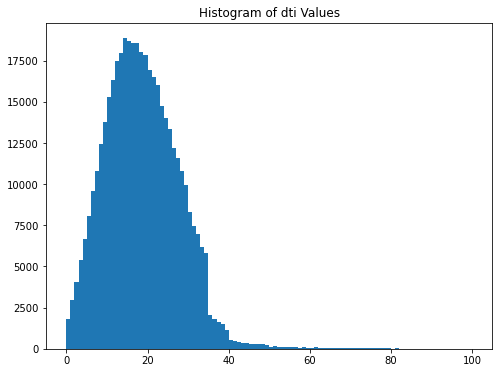

In [9]:
plt.figure(figsize=(8,6))
plt.hist(df['dti'], bins=100, range=[0,100])
plt.title("Histogram of dti Values")

print()

**annual_inc**: Distribution of annual income reveals the vast majority of incomes are within reason, with a handful of outliers towards the higher end of the spectrum (and one lucky person out there right near 10000000). Looking at data for this specific data point reveals the self-report annual income *may* not be perfectly reliable, but we won't make any adjustments for this variable here. 

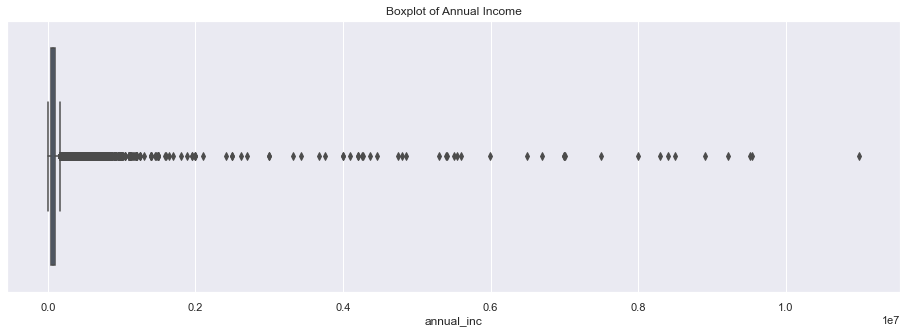

In [10]:
sns.set(rc={'figure.figsize':(16,5)})
sns.boxplot(df['annual_inc']).set_title("Boxplot of Annual Income")
print()

In [11]:
# This does seem funky. A 10 Mil earner taking a 5K loan at 18%??
# Leaving for now, but understanding the self-reported data is likely not perfect
df[df['annual_inc'] == 10999200.00]

,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,mths_since_last_delinq,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App
73001,5000,18.06,180.92,1.0,10999200.0,0.07,1,689,0.0,13.0,...,0,1,0,0,0,0,0,0,0,0


### Feature Engineering
 - There are three features that measure months since delinquency (mths_since_last_delinq, mths_since_recent_bc_dlq, and mths_since_recent_revol_delinq). As most of these are null, we will assume null values mean those borrowers have not experienced a delinquency. It could be helpful for predictions to include a binary variable for each of these indicating if there has been a delinquency or not.

In [12]:
df['dlq_bin'] = ~(df['mths_since_last_delinq'].isnull())
df['dlq_bin'] = df['dlq_bin'].astype(int)

df['bc_dlq'] = ~(df['mths_since_recent_bc_dlq'].isnull())
df['bc_dlq'] = df['bc_dlq'].astype(int)

df['revol_dlq'] = ~(df['mths_since_recent_revol_delinq'].isnull())
df['revol_dlq'] = df['revol_dlq'].astype(int)

### Train/Test Split
 - The purpose of this prediction model is to inform a potential funder of the best loans to pick as they gauge *new* lending requests on Lending Club. As such, it will make sense to split our data in a way that makes a similar temporal assumption -- that is the newest loans in the dataset are those we will be predicting for.
 - The training set here will be all loans in the data up through Q2 of 2017. The test set will be Q3 and Q4 of 2017 

In [35]:
train_quarters = ['2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2']
test_quarters = ['2017Q3', '2017Q4']

train = df[df['quarter'].isin(train_quarters)]
test = df[df['quarter'].isin(test_quarters)]

train.drop(columns='quarter', inplace=True)
test.drop(columns='quarter', inplace=True)

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

print("Train df shape:", train.shape)
print("Test df shape:", test.shape)

Train df shape: (318317, 63)
Test df shape: (120674, 63)


In [36]:
pd.DataFrame(df.isnull().sum())[:50]

,0
funded_amnt,0
int_rate,0
installment,0
emp_length,30013
annual_inc,0
dti,285
delinq_2yrs,0
fico_range_high,0
inq_last_6mths,0
mths_since_last_delinq,213676


### Imputing Missing Values:
There are 16 variables with missing values. In most cases we'll simply impute with mean values for the test and train sets with a few exceptions for special cases.   
  
The months since deliquency variables pose a difficult challenge for imputing nulls for our logistic regression. Essentially the higher the number of months since deliquency the better, *however* having null values seems to be the strongest indicator of a good borrower if that means they've had no delinquencies. Imputing as 0 would be incorrect, as with the continous scale variable these would be the riskiest borrowers. Imputing as mean wouldn't make sense either. We'll use a strategy here of imputing missing values as the highest measured value +25 months for null values. This is not an ideal imputation method for this case, but should at least be directionally correct for continous variables in these cases. Further research is needed on a sound imputation strategy here.

List of imputation method for each variable:
 - emp_length (employment length), 30K total missing values: Mean value
 - dti (debt ratio), 285 missing: Mean value. Additionally, -1 and 999 values will be replaced with the mean
 - mths_since_last_delinq (months since last delinquency), 214K missing: Max value + 25
 - revol_util (amt borrowed relative to credit), 359 missing: Mean value
 - open_act_il (open credit lines), 27 missing: Mean value
 - open_il_24m (instalment accts open, 24m), 27 missing: Mean value
 - il_util (balance to limit ratio), 60K missing: Mean value
 - open_rv_24m (revolving trades opened 24 months), 27 missing: Mean value
 - all_util (balance to credit, all), 74 missing: Mean value
 - inq_last_12m (credit inquiries, 12m), 27 missing: Mean value
 - bc_open_to_buy (open to buy on cards), 5191 missing: Mean value
 - bc_util (ratio balance to credit), 5389 missing: Mean value
 - mths_since_recent_bc	(months since acct opened), 4902 missing: Mean value
 - mths_since_recent_bc_dlq (months since bankcard delinquency), 332K missing: Max value +25
 - mths_since_recent_revol_delinq (months since revolving delinquincy), 286K missing: Max value + 25
 - percent_bc_gt_75	(pct bankcards over limit), 5217: Replace with 0

In [37]:
mean_cols = [
    'emp_length',
    'dti',
    'revol_util',
    'open_act_il',
    'open_il_24m',
    'il_util',
    'open_rv_24m',
    'all_util',
    'inq_last_12m',
    'bc_open_to_buy',
    'bc_util',
    'mths_since_recent_bc'
]


dlq_cols = [
    'mths_since_last_delinq',
    'mths_since_recent_bc_dlq',
    'mths_since_recent_revol_delinq'
]


train[mean_cols] = train[mean_cols].fillna(train[mean_cols].mean())
test[mean_cols] = test[mean_cols].fillna(test[mean_cols].mean())

train[dlq_cols] = train[dlq_cols].fillna(train[dlq_cols].max() + 25)
test[dlq_cols] = test[dlq_cols].fillna(test[dlq_cols].max() + 25)

train['percent_bc_gt_75'] = train['percent_bc_gt_75'].fillna(0)
test['percent_bc_gt_75'] = test['percent_bc_gt_75'].fillna(0)

**dti** replace values -1 and 999 with mean value

In [38]:
train_dti_mean = train[(train['dti'] != -1) & (train['dti'] != 999)]['dti'].mean()
test_dti_mean = test[(test['dti'] != -1) & (test['dti'] != 999)]['dti'].mean()

train[(train['dti'] == -1) | (train['dti'] == 999)]['dti'] = train_dti_mean
test[(test['dti'] == -1) | (test['dti'] == 999)]['dti'] = test_dti_mean

### Downsampling Training Data
 - We have an imbalanced training dataset, where only ~14% of the loans have been charged off or are late in payment. To train a useful logistic regression model, it is ideal if the balance of positive and negative classes is equal.
 - To get a balanced training set, we're going to randomly select a number of the non-risk loans to match the number of risky loans for the training set

In [39]:
# there are 42643 "risky" loans in the training data
risky_loans = train[train['risky_loan'] == 1]
good_loan_sample = train[train['risky_loan'] == 0].sample(42643)

train = pd.concat([risky_loans, good_loan_sample])
train.reset_index(inplace=True, drop=True)

print("Train data shape:", train.shape)
print("Target variable outcome counts:")
train['risky_loan'].value_counts()

Train data shape: (86286, 63)
Target variable outcome counts:


1    43643
0    42643
Name: risky_loan, dtype: int64

## Logistic Regression Model

In [40]:
X_train = train.drop(columns='risky_loan')
y_train = train['risky_loan']

test_features = test.drop(columns='risky_loan')
y_test = test['risky_loan']


# fit model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
print()

### Evaluation
 - The model does not do a very good job accurately predicting whether or not a loan would be risky; its performance on the test set only has an accuracy of 60%, whereas simply predicting the most common class (risky_loan=0) for all cases would yield an accuracy of nearly 94%
 - Even the precision of 89%, where 89% of cases predicted as non-risky would be correct, underperforms a baseline of simply guessing the most common class for all observations
 - Of note, by default the sklearn logistic regression model is going to predict a risky loan if probability is greater than .5

In [41]:
def print_metric_eval(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1 score: {f1}")
    
def plot_cm(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix, display_labels = ["Safe Loan", "Risky Loan"])
    cm_display.plot()#ax = ax[0])
    plt.title("Confusion Matrix")

In [42]:
# default .5 prediction
y_pred = logistic_model.predict(test_features)

In [43]:
print_metric_eval(y_test, y_pred)

Accuracy: 0.6013059979780234 
Precision: 0.8973751515213972 
Recall: 0.6013059979780234 
F1 score: 0.7017677400986226


 - A confusion matrix helps illustrate that the model is predicting a rather high proportion of risky loans (70420 predicted as safe, 50254 predicted as risky)
 - Further, it makes sense that the model is only properly classifying slightly over half of the actual risky loans as risky

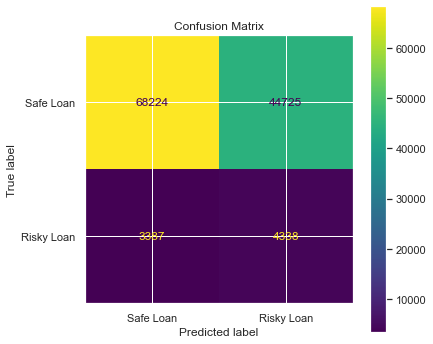

In [44]:
plot_cm(y_test, y_pred)

 - We can look at an ROC curve, comparing the tradeoff between false-positive and false-negative rates, to get an idea of how well this model performs overall and if there is possibly a better probability cutoff for classifying loans as risky
 - The fact the ROC curve is close to the y=x line tells us we have a relatively low AUC and the model probably doesn't add much in terms of predictive value, and there is no clear point on the smooth curve we could select to meaningfully improve either the false-positive or false-negative rates without sacrificing the other

In [45]:
y_pred_prob = logistic_model.predict_proba(test_features)

# get positive class probabilities from prediction proba
y_probs = [x[1] for x in y_pred_prob]

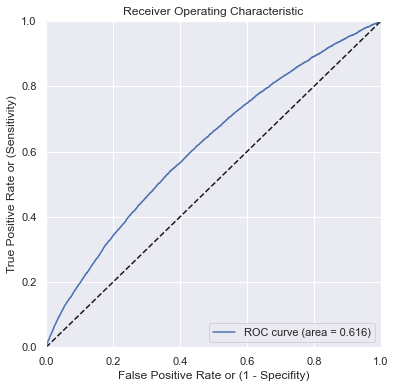

In [46]:
# ROC plot creation post: https://stackoverflow.com/questions/34564830/roc-curve-with-sklearn-python

sns.set(rc={'figure.figsize':(6,6)})
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

 - The AUC for this model is .62, suggesting it does provide a marginal gain in terms of predictive power

In [47]:
roc_auc_score(y_test, y_probs)

0.6163494564562905

 - Still, we'll try something simple here for classification and see if raising the probability for a positive class prediction will increase performance of our binary model
 - At a probability threshold of 0.6, we get a split that is about in line with the number of actual risky loans in the test set. Let's see what happens using that as our prediction cutoff.
 - Ultimately this does boost overall metrics outside of precision to all be in the range of .86 - .89, but compared to a naive guess of the most common class (93% safe loans) this model still underperforms what would be essentially random guessing

In [48]:
test['pred_probs'] = y_probs
test['classify_6'] = test['pred_probs'] >= 0.6
test['classify_6'] = test['classify_6'].astype(int)

print_metric_eval(y_test, test['classify_6'])

Accuracy: 0.8662677958798084 
Precision: 0.8894063315473716 
Recall: 0.8662677958798084 
F1 score: 0.877322350215147


- Performance aside, one of the main benefits of logistic regression is its interpretability. We can look at the top coefficients and see what variables are playing the biggest part in a risky loan prediction
- For instance here we see the size of payment installment plays the biggest factor in predicting if a loan is risky. For a unit increase in the installment, the odds of being a risky loan would go up by **exp(.002) - 1**, or 0.2%.
- Note the data here is not scaled and interpretation would be different if we had scaled the feature sets before fitting the model.

In [49]:
coef_df = pd.DataFrame({'Variable': test_features.columns,
                        'Coef': logistic_model.coef_[0]})

coef_df.sort_values('Coef', ascending=False, inplace=True)
coef_df[:10]

,Variable,Coef
2,installment,0.002424
16,il_util,0.000747
1,int_rate,0.000557
18,all_util,0.000460
35,percent_bc_gt_75,0.000398
5,dti,0.000332
21,acc_open_past_24mths,0.000240
34,pct_tl_nvr_dlq,0.000211
29,num_rev_accts,0.000195
23,bc_util,0.000185


- In addition to interpretability, another benefit of using logistic regression here is we essentially have a ranking of loans because we're calculating a probability. 
- If the goal is to pick the best investments, we could simply assign our probabilities to our test set and sort by probability, then pick say the top 1000 safest loans
- Using this method to pick the best loans would give a decent proportion -- 97% would be non-risky loans -- but this is still only marginally better than random picking

In [50]:
test['risky_prob'] = y_probs

test.sort_values('risky_prob', inplace=True)
test.reset_index(inplace=True, drop=True)
print("Selected loans risky_loan value counts:")
test[:1000]['risky_loan'].value_counts()

Selected loans risky_loan value counts:


0    967
1     33
Name: risky_loan, dtype: int64

## Summary
 - The logistic regression model provides the benefits of interpretability, a probabilistic estimate for our outcome variably, and is a relatively small and simple model overall. It will nevertheless give us a good starting point for comparison as we test other models for better performance.
 - However, this model is not great in terms of performance, with an out of the box accuracy of just 60% and relatively low precision (89%) and recall (60%).

## Further work
### Logistic Regression Modeling
If our goal is to get the best, most interpretable logistic model in place for this task there are a few next steps to take:
 - **More Feature Engineering**: In this example the only new variables created were the binary delinquency variables. Further exploration and creation of new variables could lead to a better predictive model.
 - **Feature Selection**: There is no doubt high multi-collinearity in this dataset. We could use the variance inflation factor to trim out extraneous variables that are highly correlated with other features in the dataset (good post on VIF here: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/). This would make our model's coefficients more interpretable.
 - **Dimension Reduction**: We could use principle component analysis to reduce the size of the feature space while maintaing as much variance as possible. This could halp make our model much smaller (though would lose interpretability).  
   
### Try Other Models
 - Especially if the use case is strictly classification of risky/non-risky loans, there are a number of more sophisticated models that would be worth trying out. This dataset has been fairly well publicised, with strong performance from random forests and neural nets available on kaggle (https://www.kaggle.com/datasets/urstrulyvikas/lending-club-loan-data-analysis/data)